# Airline Sentiment Analysis

Detecting negative sentiments

## Table of Contents:
* [Data Collection](#DataCollection)
* [Data Organization](#DataOrganization)
* [Data Definition](#DataDefinition)
* [Data Cleaning](#DataCleaning)
    * [Vectorization](#Vectorization)
* [Model](#Model)
    * [Naive Bayes](#nb)
    * [Random Forest Classifier](#rf)
    * [Logistic Regression](#lr)
    * [N-grams](#ng)
    * [ROC-AUC Comparisons](#roc)
    * [Precision Recall](#pr)
    * [Thresholding](#thresholding)
        * [Classification Report](#cr)
        * [Confusion Matrix](#cm)
* [Summary](#summary) 

In [1]:
#imports
import pandas as pd
import numpy as np
#this will deal with punctuation
import string
import re
#from string import digits
import nltk #using the Natural Language Toolkit
from nltk.corpus import stopwords
#Lemmatization
from nltk.stem import WordNetLemmatizer
import emoji
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import math
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, fbeta_score, recall_score, accuracy_score, f1_score, precision_score

# 1. Data Collection <a class="anchor" id="DataCollection"></a>

In [2]:
#get data
tweets = pd.read_csv("../Data/Tweets.csv")

# 2. Data Organization <a class="anchor" id="DataOrganization"></a>

In [3]:
#view the heading of data
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


In [4]:
#check shape
print(tweets.shape)
print(tweets.info())

(14640, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  ob

In [5]:
#check for null values
print(tweets.isnull().sum())

#percentage of null values
print(((tweets.isnull().sum() * 100)/ len(tweets.index)))

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64
tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
airline_sentiment_gold          99.726776
name                             0.000000
negativereason_gold             99.781421
retweet_count                    0.0000

"airline_sentiment_gold" , "negativereason_gold", and "tweet_coord" columns are missing over 90% of their input. I will drop them

In [6]:
tweets = tweets.drop(columns=["airline_sentiment_gold" , "negativereason_gold", "tweet_coord"])

#check for more null values
print(tweets.isnull().sum())

print(((tweets.isnull().sum() * 100)/ len(tweets.index)))

tweet_id                           0
airline_sentiment                  0
airline_sentiment_confidence       0
negativereason                  5462
negativereason_confidence       4118
airline                            0
name                               0
retweet_count                      0
text                               0
tweet_created                      0
tweet_location                  4733
user_timezone                   4820
dtype: int64
tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  37.308743
negativereason_confidence       28.128415
airline                          0.000000
name                             0.000000
retweet_count                    0.000000
text                             0.000000
tweet_created                    0.000000
tweet_location                  32.329235
user_timezone                   32.923497
dtype: float64


# 3. Data Definition <a class="anchor" id="DataDefinition"></a>

                    
 1   airline_sentiment              
 2   airline_sentiment_confidence  
 3   negativereason                 
 4   negativereason_confidence    
 5   airline                        
 6   airline_sentiment_gold         
 7   name                          
 8   negativereason_gold            
 9   retweet_count                 
 10  text                           
 11  tweet_coord                  
 12  tweet_created                 
 13  tweet_location                
 14  user_timezone   

# 4. Data Cleaning <a class="anchor" id="DataCleaning"></a>

The following needs to be done to preprocess the data:

1. Make text lowercase
2. Removing punctuations, URLs, names
3. Tokenization
4. Removing stopwords ("this", "is", etc.)
4. Lemmatizing

In [7]:
#Lowercase
tweets["text"] = tweets["text"].str.lower()

#remove numbers
tweets["text"] = tweets["text"].str.replace('\d+', '', regex=True)

##REMOVE PUNCTUATIONS
def remove_punc(text):
    words_wo_punct = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    return words_wo_punct

tweets["text"] = tweets["text"].apply(lambda x: remove_punc(x))

In [8]:
#REMOVE WHITESPACE
tweets["text"] = tweets["text"].str.strip()

#remove emoji
tweets["text"] = tweets["text"].apply(lambda x: emoji.demojize(x))
tweets["text"].head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercials to ...
2    virginamerica i didnt today must mean i need t...
3    virginamerica its really aggressive to blast o...
4    virginamerica and its a really big bad thing a...
Name: text, dtype: object

In [9]:
#LEMMATIZING
lemmatizer = WordNetLemmatizer()

def word_lemmatizer(text):
    word_list = nltk.word_tokenize(text)
    lem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lem_text

tweets["text"] = tweets["text"].apply(lambda x: word_lemmatizer(x))
tweets.text.head()

0                     virginamerica what dhepburn said
1    virginamerica plus youve added commercial to t...
2    virginamerica i didnt today must mean i need t...
3    virginamerica it really aggressive to blast ob...
4    virginamerica and it a really big bad thing ab...
Name: text, dtype: object

In [10]:
#REMOVE STOPWORDS and tokenize
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    
    return tokens_wo_stopwords

tweets["text"] = tweets["text"].apply(lambda x: remove_stopwords(str(x)))
tweets["text"].head()

0                      [virginamerica, dhepburn, said]
1    [virginamerica, plus, youve, added, commercial...
2    [virginamerica, didnt, today, must, mean, need...
3    [virginamerica, really, aggressive, blast, obn...
4             [virginamerica, really, big, bad, thing]
Name: text, dtype: object

## Polarity

In [11]:
from textblob import TextBlob, Word, Blobber
tweets['polarity']=tweets['text'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,polarity
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,"[virginamerica, dhepburn, said]",2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0.0000
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,"[virginamerica, plus, youve, added, commercial...",2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),0.0000
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,"[virginamerica, didnt, today, must, mean, need...",2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),-0.3125


### Vectorization <a class="anchor" id="Vectorization"></a>

Base model

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

In [13]:
tweets.shape

(14640, 13)

In [14]:
### Change Text to String ###
tweets["text"] = tweets["text"].astype(str)

### Remove neutral sentiment to focus on just the positive and negative sentiment ###
tweets = tweets[tweets["airline_sentiment"] != "neutral"]

### Change sentiment to int ###
def changeSentiment(sentiment):
    if  sentiment == "positive":
        return 0
    elif sentiment == "negative":
        return 1
    
tweets['airline_sentiment'] = tweets['airline_sentiment'].apply(lambda x : changeSentiment(x))

In [15]:
tweets.shape

(11541, 13)

### CountVec

In [16]:
### Train Test Split ###
cv = CountVectorizer(min_df=5, max_df=0.70)
X = cv.fit_transform(tweets.text)
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

#### get base model with Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg.score(X_test, y_test)))

training_accuracy = logReg.score(X_train, y_train)
test_accuracy = logReg.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, logReg.predict_proba(X_test)[:,1]))

Logistic Regression Accuracy: 91.48%
Accuracy on training data: 0.96
Accuracy on test data:     0.91
0.9538631890992197


### Tf-idf 

In [18]:
td = TfidfVectorizer(min_df=5, max_df=0.70)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

In [19]:
logReg2 = LogisticRegression(max_iter=1000).fit(X_train, y_train)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * logReg2.score(X_test, y_test)))

training_accuracy = logReg2.score(X_train, y_train)
test_accuracy = logReg2.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, logReg2.predict_proba(X_test)[:,1]))

Logistic Regression Accuracy: 90.47%
Accuracy on training data: 0.92
Accuracy on test data:     0.90
0.9536694879800467


Vectorizing with CountVec performed the best.

# Model Selection <a class="anchor" id="Model"></a>

In [20]:
cv = CountVectorizer(min_df=5, max_df=0.70)
X = cv.fit_transform(tweets['text'])
y = tweets['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)

## Naive Bayes <a class="anchor" id="nb"></a>

In [21]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(X_train, y_train)

### Print accuracy ###
print("Naive Bayes Accuracy: %0.2f%%" % (100 * mnb.score(X_test, y_test)))

training_accuracy = mnb.score(X_train, y_train)
test_accuracy = mnb.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, mnb.predict_proba(X_test)[:,1]))

Naive Bayes Accuracy: 90.30%
Accuracy on training data: 0.93
Accuracy on test data:     0.90
0.9486707011081901


In [22]:
### Get false positive rate and the true positive rate ###
mnb_probs = mnb.predict_proba(X_test)[:,1]
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test, mnb_probs)

## Random Forest Classifier <a class="anchor" id="rf"></a>

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)

### Print accuracy ###
print("Random Forest Accuracy: %0.2f%%" % (100 * rf.score(X_test, y_test)))

training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, logReg.predict_proba(X_test)[:,1]))

Random Forest Accuracy: 89.89%
Accuracy on training data: 1.00
Accuracy on test data:     0.90
0.9538631890992197


## Lets Improve the Model

In [24]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [None, 25, 50], 
    'max_features': ['auto'], 
    'n_estimators': [100, 300, 400]
}

rf_gs = GridSearchCV(rf, parameters, cv=5, scoring = "roc_auc") 
rf_gs.fit(X_train, y_train)

print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'max_depth': 50, 'max_features': 'auto', 'n_estimators': 400}
0.9278067515827662


In [25]:
rf = RandomForestClassifier(max_depth= 50, max_features= 'auto', n_estimators = 400).fit(X_train, y_train)

### Print accuracy ###
print("Random Forest Accuracy: %0.2f%%" % (100 * rf.score(X_test, y_test)))

training_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, rf.predict_proba(X_test)[:,1]))

Random Forest Accuracy: 89.43%
Accuracy on training data: 0.95
Accuracy on test data:     0.89
0.9302041949272274


In [26]:
### Get false positive rate and the true positive rate ###
rf_probs = rf.predict_proba(X_test)[:,1]
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_probs)

## Logistic Regression <a class="anchor" id="lr"></a>

The Logistic Regression model performed the best. 

In [27]:
lr = LogisticRegression(max_iter=1000).fit(X_train, y_train)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * lr.score(X_test, y_test)))

training_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression Accuracy: 91.48%
Accuracy on training data: 0.96
Accuracy on test data:     0.91
0.9538631890992197


## The base model performed the best. 

## Let's improve the model

In [28]:
### Logistic Regression GridSearchCV ###
parameters = {
    'C' : [.01, .001, 1, 10, 100],
    'max_iter': [1000, 10000]
}

lr_gs = GridSearchCV(lr, parameters, cv=5, scoring = "roc_auc") 
lr_gs.fit(X_train, y_train)

print(lr_gs.best_params_)
print(lr_gs.best_score_)

{'C': 1, 'max_iter': 1000}
0.9494612677972789


In [29]:
lr = LogisticRegression(max_iter=1000, C=1).fit(X_train, y_train)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * lr.score(X_test, y_test)))

training_accuracy = lr.score(X_train, y_train)
test_accuracy = lr.score(X_test, y_test)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test, lr.predict_proba(X_test)[:,1]))

Logistic Regression Accuracy: 91.48%
Accuracy on training data: 0.96
Accuracy on test data:     0.91
0.9538631890992197


# Let's try with N-grams <a class="anchor" id="ng"></a>

## CountVect

In [30]:
ngram = (1,2)
cv = CountVectorizer(ngram_range=ngram)
X = cv.fit_transform(tweets['text'])
y = tweets['airline_sentiment']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=.30, random_state=0)

lr2 = LogisticRegression(max_iter=1000, C=1).fit(X_train2, y_train2)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * lr2.score(X_test2, y_test2)))
y_pred =lr2.predict(X_test2)
training_accuracy = lr2.score(X_train2, y_train2)
test_accuracy = lr2.score(X_test2, y_test2)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score( y_test2, lr2.predict_proba(X_test2)[:,1]))

Logistic Regression Accuracy: 91.60%
Accuracy on training data: 1.00
Accuracy on test data:     0.92
0.952112390581333


## TF-IDF

In [31]:
ngram = (1,2)
td = TfidfVectorizer(ngram_range=ngram)
X = td.fit_transform(tweets['text'])
y = tweets['airline_sentiment']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=.30, random_state=0)

lr3 = LogisticRegression(max_iter=1000, C=1).fit(X_train3, y_train3)

### Print accuracy ###
print("Logistic Regression Accuracy: %0.2f%%" % (100 * lr3.score(X_test3, y_test3)))
y_pred =lr3.predict(X_test3)
training_accuracy = lr3.score(X_train3, y_train3)
test_accuracy = lr3.score(X_test3, y_test3)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))
print(roc_auc_score(y_test3, lr3.predict_proba(X_test3)[:,1]))

Logistic Regression Accuracy: 87.09%
Accuracy on training data: 0.91
Accuracy on test data:     0.87
0.9454711380340135


In [32]:
### Get false positive rate and the true positive rate for lr ###
lr_probs = lr.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_probs)

### The lr performed the best based on roc_auc score and accuracy.

## ROC Curve Comparisons <a class="anchor" id="roc"></a>

Below compares the three models based on the ROC-AUC (Receiver Operating Characteristic-Area Under the Curve) to visualize the tradeoff between the classifier’s sensitivity and specificity.

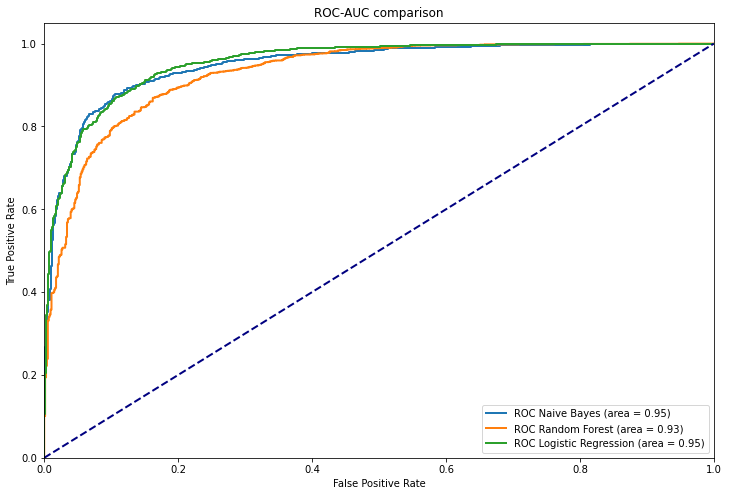

In [33]:
plt.figure(figsize=(12,8))

for fpr, tpr, model in [(mnb_fpr,mnb_tpr,'Naive Bayes'),(rf_fpr,rf_tpr,'Random Forest'),(lr_fpr,lr_tpr,'Logistic Regression')]:
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             lw=2, label='ROC '+ model + ' (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC comparison')
plt.legend(loc="lower right")
plt.show()

# Precision Recall Curve <a class="anchor" id="pr"></a>

The Precision Recall Curve shows the tradeoff between a classifier’s precision (a measure of result relevancy) and recall(a measure of completeness). For each class, precision is defined as the ratio of true positives to the sum of true and false positives, and recall is the ratio of true positives to the sum of true positives and false negatives. My model has an average precision of 0.99.

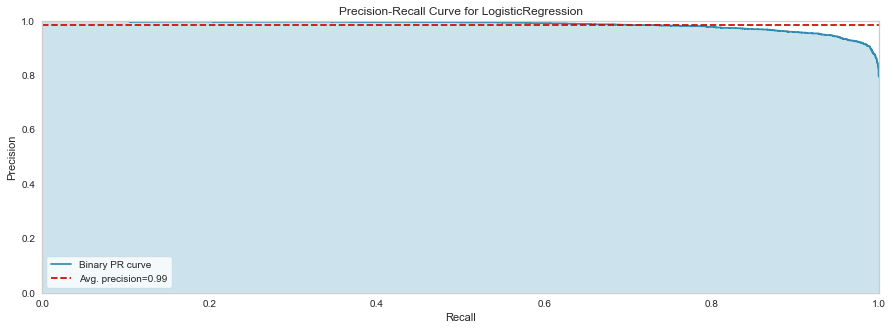

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [34]:
from yellowbrick.classifier import PrecisionRecallCurve, DiscriminationThreshold
fig, ax = plt.subplots(figsize=(15,5))
viz = PrecisionRecallCurve(lr)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Thresholding <a class="anchor" id="thresholding"></a>

# Classification Report <a class="anchor" id="cr"></a>

In [35]:
### Classification Report of current threshold ###

y_pred = lr.predict(X_test)
class_report = classification_report(y_test,y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.86      0.72      0.78       734
           1       0.93      0.97      0.95      2729

    accuracy                           0.91      3463
   macro avg       0.89      0.84      0.86      3463
weighted avg       0.91      0.91      0.91      3463



## Visualize accuracy with Confusion Matrix <a class="anchor" id="cm"></a>

The recall score is: 0.97
The precision score is: 0.93 

Accuracy score is: 0.91
The F1 score is: 0.95


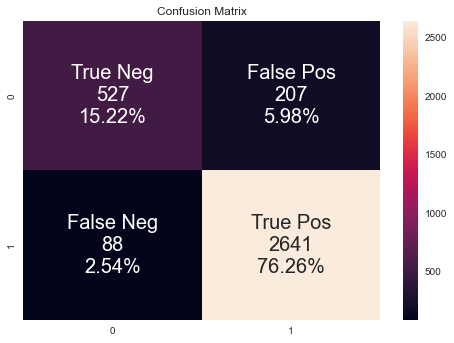

In [36]:
### Get Confusion Matrix ###
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

### Visualize Confusion Matrix ###
groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
groupCount = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
groupPercent = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(groupNames,groupCount,groupPercent)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='rocket', annot_kws={"fontsize":20})
plt.title("Confusion Matrix")

print("The recall score is: %.2f" % recall_score( y_test, y_pred))
print("The precision score is: %.2f" % precision_score( y_test, y_pred),"\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, y_pred))
print("The F1 score is: %.2f" % f1_score( y_test, y_pred))

## Best Threshold

## Optimize Balanced accuracy

In [37]:
y_pred = lr.predict(X_test)
score = balanced_accuracy_score(y_test, y_pred)
print('Balance Accuracy: %.5f' % score)

# predict probabilities
y_pred = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = y_pred[:, 1]

# define thresholds > test between between 0.0 and 1.0
thresholds = np.arange(0.0, 1.0, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores = [balanced_accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Balance Accuracy=%.5f' % (thresholds[ix], scores[ix]))

Balance Accuracy: 0.84287
Threshold=0.827, Balance Accuracy=0.88133


## Optimize F1 Score

In [38]:
y_pred = lr.predict(X_test)
score = f1_score(y_test, y_pred)
print('F-Score: %.5f' % score)

# predict probabilities
y_pred = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = y_pred[:, 1]

# define thresholds > test between between 0.0 and 1.0
thresholds = np.arange(0.0, 1.0, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

F-Score: 0.94710
Threshold=0.448, F-Score=0.94900


## Optimize Recall

In [39]:
from sklearn.metrics import recall_score
# evaluate the model
#yhat = model.predict(testX)
y_pred = lr.predict(X_test)
score = recall_score(y_test, y_pred)
print('Recall Score: %.5f' % score)

# predict probabilities
y_pred = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = y_pred[:, 1]

# define thresholds > test between between 0.0 and 1.0
thresholds = np.arange(0.0, 1.0, 0.001)

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores = [recall_score(y_test, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, Recall Score=%.5f' % (thresholds[ix], scores[ix]))

Recall Score: 0.96775
Threshold=0.000, Recall Score=1.00000


## Optimize Precision

In [40]:
from sklearn.metrics import precision_score

y_pred = lr.predict(X_test)
score = precision_score(y_test, y_pred)
print('Precision Score: %.5f' % score)

### predict probabilities ###
y_pred = lr.predict_proba(X_test)

### keep probabilities for the positive outcome only ###
probs = y_pred[:, 1]

### define thresholds > test between between 0.0 and 1.0 ###
thresholds = np.arange(0.0, 1.0, 0.001)

### apply threshold to positive probabilities to create labels ###
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

### evaluate each threshold ###
scores = [precision_score(y_test, to_labels(probs, t)) for t in thresholds]

### get best threshold ###
ix = np.argmax(scores)
print('Threshold=%.3f, Precision Score=%.5f' % (thresholds[ix], scores[ix]))

Precision Score: 0.92732
Threshold=0.994, Precision Score=0.99785


In [41]:
def precision_recall(model, X_test, y_test, threshold, beta=1):
    
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    cm = confusion_matrix(y_test, y_pred)
    
    fp = cm[0,1]
    tp = cm[1,1]
    fn = cm[1,0]
    tn = cm[0,0]
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    bal_acc=balanced_accuracy_score(y_test,y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, bal_acc, fbeta])

In [42]:
threshold_df = pd.DataFrame(columns=['Precision','Recall', 'Balance Accuracy', "F1-Measure"])

for threshold in np.arange(0.0, 1.0, 0.001):
    
    threshold_df.loc[threshold] = precision_recall(lr, X_test, y_test, threshold)

## Best Threshold - Balance Accuracy

Balance Accuracy is used when you have imbalanced data.

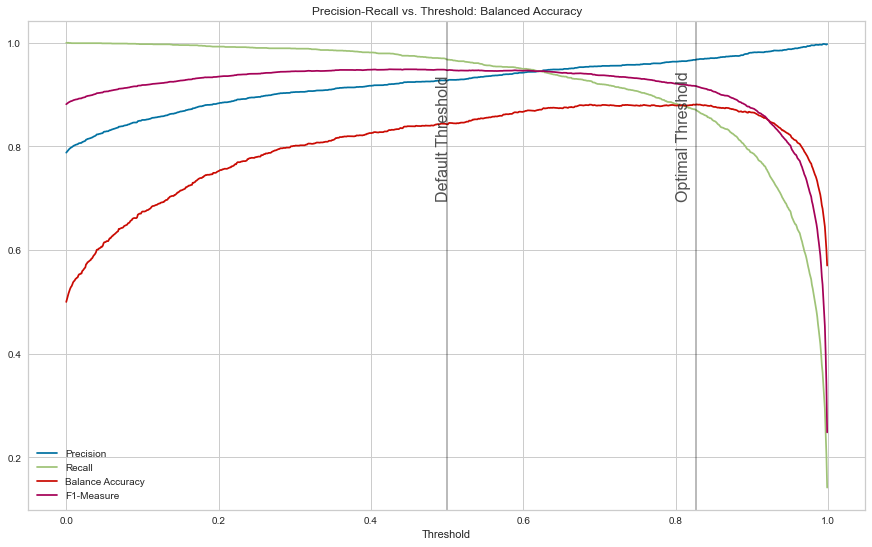

In [43]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold: Balanced Accuracy')
ax.axvline(0.827, color='black', alpha=0.3)
ax.text(0.800,.7,'Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8, fontsize=16);

## Business Case 1 - Optimize Recall

If an airline company uses this model, they can use this to track their customer sentiment. In this scenario the company would want to optimize the recall because we want to get all of the  positive classes which are the negative sentiment tweets. The managers then can analyze the tweets and be able to make an assessment on what needs to be improved for the company so they improve customer relations and not lose money. 

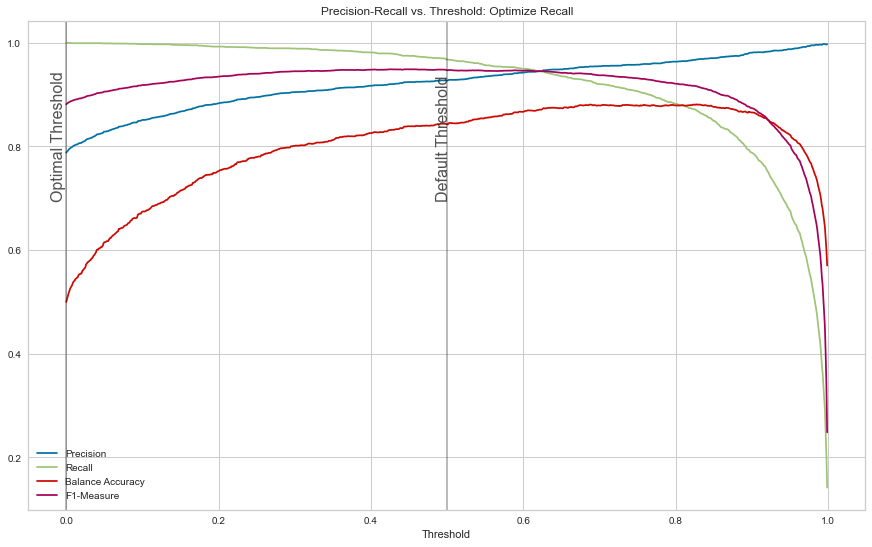

In [44]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold: Optimize Recall')
ax.axvline(0.0, color='black', alpha=0.3)
ax.text(-0.02,.7,'Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8, fontsize=16);

## Business Case 2 - Optimize Precision

If airlines have this model, they can predict if the sentiment is negative or positive. They can then have a bot to alert customers with a message if it is a positive sentiment like "Thank you for flying with us. We look forward to seeing you on your next trip." If it is a negative sentiment, a bot can send a similar tweet saying "Sorry for the unsatisfactory experience. Can you please dm us." The bot can then send an alert to a customer service representative, and a discount or refund can be offered to the customer.

In this scenario, we would need to optimize the precision. We want to minimize the false positives. If there are tweets that are positive but are predicted as negative, we don't need bots and customer service representatives wasting time and money on responding to customers and offering discounts.

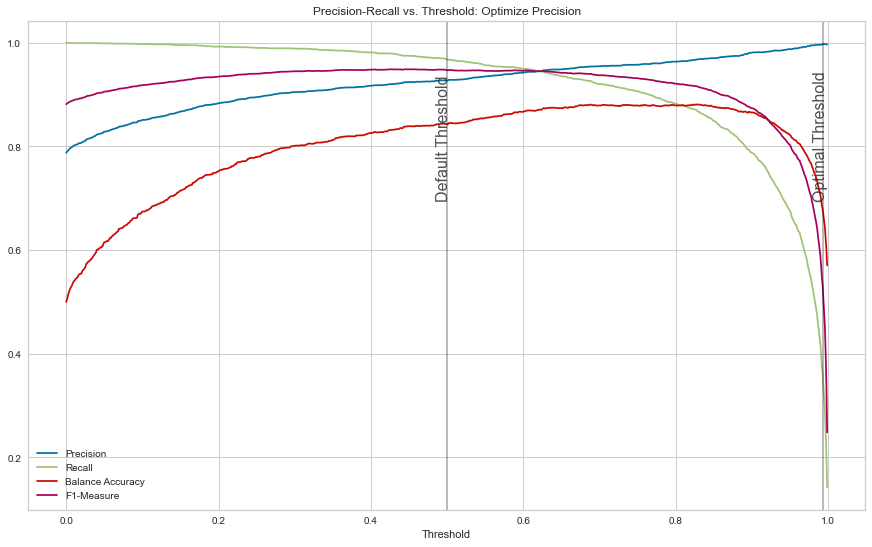

In [45]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold: Optimize Precision')
ax.axvline(0.994, color='black', alpha=0.3)
ax.text(0.980,.7,'Optimal Threshold',rotation=90, alpha=0.8, fontsize=16)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8, fontsize=16);

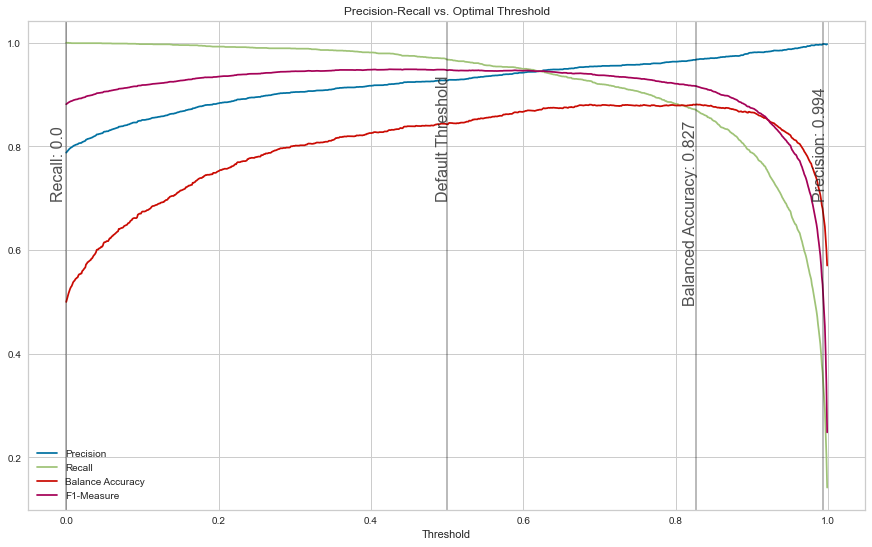

In [46]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Optimal Threshold')

ax.axvline(0.0, color='black', alpha=0.3)
ax.text(-0.02,.7,'Recall: 0.0',rotation=90, alpha=0.8, fontsize=16)

ax.axvline(0.827, color='black', alpha=0.3)
ax.text(0.810,.5,'Balanced Accuracy: 0.827',rotation=90, alpha=0.8, fontsize=16)

ax.axvline(0.994, color='black', alpha=0.3)
ax.text(0.980,.7,'Precision: 0.994',rotation=90, alpha=0.8, fontsize=16)

ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.7,'Default Threshold',rotation=90, alpha=0.8, fontsize=16);

## Precision

In [47]:
y_pred = (lr.predict_proba(X_test)[:,1] >= 0.70).astype(bool)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       734
           1       0.95      0.92      0.94      2729

    accuracy                           0.90      3463
   macro avg       0.85      0.88      0.86      3463
weighted avg       0.91      0.90      0.91      3463



The recall score is: 0.92
The precision score is: 0.95 

Accuracy score is: 0.90
The F1 score is: 0.94


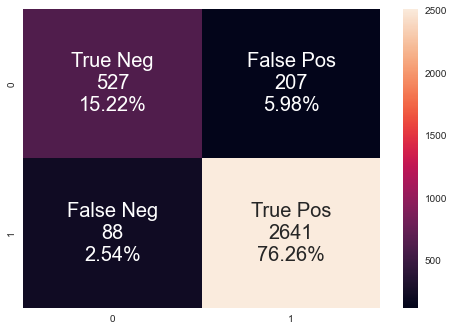

In [48]:
predictions = lr.predict_proba(X_test)[:,1] >= 0.70

print("The recall score is: %.2f" % recall_score( y_test, predictions))
print("The precision score is: %.2f" % precision_score( y_test, predictions),"\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
groupCount = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
groupPercent = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groupNames,groupCount,groupPercent)]
labels = np.asarray(labels).reshape(2,2)

cm = confusion_matrix(y_test , predictions )
sns.heatmap(cm, annot=labels, annot_kws={"size": 20}, fmt="", cmap="rocket")
plt.show()

## Recall

In [49]:
y_pred = (lr.predict_proba(X_test)[:,1] >= 0.30).astype(bool)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       734
           1       0.90      0.99      0.95      2729

    accuracy                           0.91      3463
   macro avg       0.92      0.80      0.84      3463
weighted avg       0.91      0.91      0.90      3463



The recall score is: 0.99
The precision score is: 0.90 

Accuracy score is: 0.91
The F1 score is: 0.95


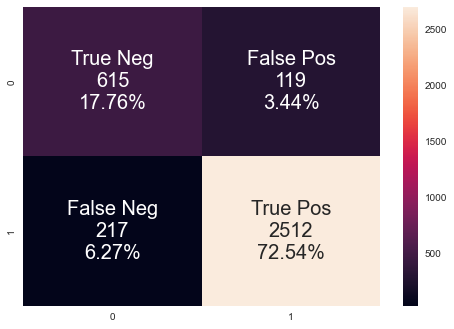

In [50]:
predictions = lr.predict_proba(X_test)[:,1] >= 0.30

print("The recall score is: %.2f" % recall_score( y_test, predictions))
print("The precision score is: %.2f" % precision_score( y_test, predictions),"\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
groupCount = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
groupPercent = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groupNames,groupCount,groupPercent)]
labels = np.asarray(labels).reshape(2,2)

cm = confusion_matrix(y_test , predictions )
sns.heatmap(cm, annot=labels, annot_kws={"size": 20}, fmt="", cmap="rocket")
plt.show()

# Threshold moved based on Balance Accuracy

In [51]:
y_pred = (lr.predict_proba(X_test)[:,1] >= 0.827).astype(bool)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75       734
           1       0.97      0.87      0.92      2729

    accuracy                           0.87      3463
   macro avg       0.81      0.88      0.83      3463
weighted avg       0.90      0.87      0.88      3463



The recall score is: 0.87
The precision score is: 0.97 

Accuracy score is: 0.87
The F1 score is: 0.92


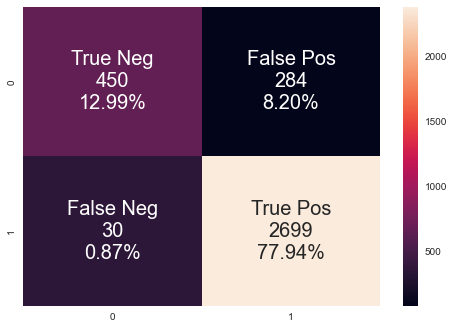

In [52]:
### Confusion Matrix with best Threshold ###

predictions = lr.predict_proba(X_test)[:,1] >= 0.827

print("The recall score is: %.2f" % recall_score( y_test, predictions))
print("The precision score is: %.2f" % precision_score( y_test, predictions),"\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

groupNames = ["True Neg", "False Pos", "False Neg", "True Pos"]
groupCount = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
groupPercent = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(groupNames,groupCount,groupPercent)]
labels = np.asarray(labels).reshape(2,2)

cm = confusion_matrix(y_test , predictions )
sns.heatmap(cm, annot=labels, annot_kws={"size": 20}, fmt="", cmap="rocket")
plt.show()

# Summary <a id="summary"></a>

This model can help airline companies understand their customer sentiment. Depending on how this model will be used, you can change the threshold based on optimizing the balance accuracy, precision, or recall. 

Based on this dataset, there are mainly negative sentiments.